In [1]:
import os
import sys
import cv2
import glob 
import torch
import random 
import resource 
import numpy as np
from math import exp
import torch.nn as nn 
from PIL import Image
from models.memae import *
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader 
 

In [63]:
def gaussian(window_size, sigma):
    """
    Args:
        window_size: Size of Gaussian window
        sigma: mean for the gaussian

    Returns:
        gauss. a gaussian matrix with mean equal to sigma and size equal to window size 
    """
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    """
    Args:
        window_size: Size of Gaussian window
        channel: number of channels in the gaussian filter

    Returns:
        window: Gaussian tensor
    """
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = False):
    """
    Args:
        img1: image one to be compared
        img2: image two to be compared
        window: the Gaussian window
        window_size: size of the Gaussian Window
        channel: number of output channels
        size_average: take mean of the final similarity matrix or not

    Returns:
        ssim_map: Structural similarity index of two images
    """
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average and False: 
        return ssim_map.mean()
    else:
        return ssim_map
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    """ 
    Class for SSIM loss 
      
    Attributes: 
        size_average: Take mean of the loss or not 
        window_size: size of similarity window 
    """
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)
         
    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel

        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

 

In [74]:
class MemDataset(Dataset):
    """Memory Auto Encoder Dataset"""

    def __init__(self,root_dir,start,end,train=True):
        """
        Args:
            root_dir : Directory with all the images.
            start : starting index of images to include in this set
            end : ending index of images to include in this set
            train : train or test
        """
        self.transform=transforms.Compose([    transforms.Resize((98,98)), 
                                               transforms.Grayscale(num_output_channels=1),
                                               transforms.ToTensor()
                                           ])
        self.train = train
        self.dataset = glob.glob(root_dir)[start:end] 
       

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_name = self.dataset[idx]
        im = np.array(Image.open(img_name))  
        im = Image.fromarray(im) 
        im = self.transform(im)
        return im,im
     
test_bad = MemDataset('../defect/datasets/infineon/train_memae/test_bad/*',00,1000,False)

print  ("\nTest defective", test_bad.__len__() )
 
dl_test_bad = torch.utils.data.DataLoader(test_bad,batch_size=1, shuffle=False,
                                             num_workers=4)



Test defective 462


In [75]:
import torchvision
model = MEMAE(300).cuda()
model.load_state_dict(torch.load("./ckpts/l2_seg_ckpt/60.pt")) 
resnet = torchvision.models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))


In [76]:
 
def train(model,dataloader,criteria,optimizer,train=True,step=100):
    losses = list() 
    if not train:
        model.eval()
    else:
        model.train()
    for i,(im,lab) in enumerate(dataloader):
        optimizer.zero_grad() 
        outputs = model(im.cuda())  
        #Minimize the similarity difference
        loss =  criteria(outputs, lab.cuda()) 
        refiner_output = criteria(outputs,model(outputs))
        refined_loss = cv2.GaussianBlur(loss.clone().cpu().detach().numpy()[0].reshape(98,98),(9,9),0) -  refiner_output.cpu().detach().numpy()[0].reshape(98,98)
        refined_loss_sorted = np.sort(refined_loss.reshape(-1)) 
#         losses.append(np.median(refined_loss_sorted)*np.median(refined_loss_sorted[-50:])) 
        phase = "Train" if train else "Test" 
        if i % 10 == 0:
             print (phase," Iteration: ",i,"LOSS : ",np.mean(refined_loss),"min:",np.min(refined_loss),"max:",np.max(refined_loss)\
               ,"med:",np.median(refined_loss),"zero:",refined_loss[refined_loss==0].shape)
        
        if i % step == 0 and  not train:
            difference = np.abs(im.cpu().detach().numpy().reshape(98,98) - outputs.cpu().detach().numpy().reshape(98,98))
            print (phase," Iteration: ",i,"LOSS : ",np.mean(refined_loss),"min:",np.min(refined_loss),"max:",np.max(refined_loss)\
               ,"med:",np.median(refined_loss),"zero:",refined_loss[refined_loss==0].shape) 
            inn = im.cpu().detach().numpy()[0]
            inn = np.transpose(inn,(1,2,0)) 
            outputs = outputs.cpu().detach().numpy()[0]  
            outputs[outputs>1]=1
            outputs = np.transpose(outputs,(1,2,0))[:,:,0] 
             
            difference[difference<0.02]=0
            thr = cv2.GaussianBlur(difference,(19,19),0)
            _,thr = cv2.threshold((thr*255).astype('uint8'),0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            difference*=thr
            losses.append((difference,inn)) 
        if train:
            loss.mean().backward()
            optimizer.step()
    
    return losses

def calculate_acc(loss_lists):
    
    neg_np =  (np.array(loss_lists[0]))
    pos_np =  (np.array(loss_lists[1]))
    pos_np *=1000
    neg_np *=1000
    start,end = np.median(pos_np),np.median(neg_np) 
    
    thresholds = np.linspace(start, end, num=1000)
    accuracy = 0
    thres = 0
    print (pos_np.shape,neg_np.shape)
    
    for threh in thresholds: 
        current_acc = ((pos_np[pos_np<threh].shape[0])+(neg_np[neg_np>=threh].shape[0])) / (pos_np.shape[0]+neg_np.shape[0])
        if accuracy < current_acc:
            accuracy = current_acc
            thres  = threh
                                                                                          
    print (accuracy,thres)
    print ("Positive",pos_np[pos_np<thres].shape,"Anomaly",neg_np[neg_np>=thres].shape, "Distribution")
    return accuracy,thres

In [77]:
criteria = nn.MSELoss(reduction='none' ).cuda()
s_loss = SSIM().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_lists = list() 
losses = train(model,dl_test_bad,criteria,optimizer,False,1)
loss_lists.append(losses)
             
 

Test  Iteration:  0 LOSS :  5.9606853e-05 min: -9.0753245e-05 max: 0.009373846 med: 1.5687881e-05 zero: (0,)
Test  Iteration:  0 LOSS :  5.9606853e-05 min: -9.0753245e-05 max: 0.009373846 med: 1.5687881e-05 zero: (0,)
Test  Iteration:  1 LOSS :  2.8883396e-05 min: -0.0003177683 max: 0.0015313787 med: 1.1327643e-05 zero: (0,)
Test  Iteration:  2 LOSS :  6.753736e-05 min: -0.00020104708 max: 0.011272353 med: 1.4421103e-05 zero: (0,)
Test  Iteration:  3 LOSS :  1.9710218e-05 min: -0.00012660955 max: 0.00034268634 med: 1.3817015e-05 zero: (0,)
Test  Iteration:  4 LOSS :  0.00013099595 min: -0.00019677784 max: 0.018414918 med: 1.8075269e-05 zero: (0,)
Test  Iteration:  5 LOSS :  1.9929159e-05 min: -0.00011231358 max: 0.00035591802 med: 1.2811977e-05 zero: (0,)
Test  Iteration:  6 LOSS :  0.00017723057 min: -0.00046061169 max: 0.009060149 med: 1.962186e-05 zero: (0,)
Test  Iteration:  7 LOSS :  6.725594e-05 min: -0.00022729735 max: 0.011238475 med: 1.6476462e-05 zero: (0,)
Test  Iteration:  

Test  Iteration:  82 LOSS :  3.1491116e-05 min: -0.00024388431 max: 0.0036644072 med: 1.2646153e-05 zero: (0,)
Test  Iteration:  83 LOSS :  5.7037898e-05 min: -0.00011193822 max: 0.009372798 med: 1.4726134e-05 zero: (0,)
Test  Iteration:  84 LOSS :  0.00021025882 min: -0.0005242804 max: 0.009846111 med: 2.229272e-05 zero: (0,)
Test  Iteration:  85 LOSS :  3.3213746e-05 min: -9.459436e-06 max: 0.0018464589 med: 1.5878433e-05 zero: (0,)
Test  Iteration:  86 LOSS :  2.9452338e-05 min: -8.891379e-05 max: 0.0020069215 med: 1.4065627e-05 zero: (0,)
Test  Iteration:  87 LOSS :  5.642404e-05 min: -0.00024019339 max: 0.0048252675 med: 1.9099409e-05 zero: (0,)
Test  Iteration:  88 LOSS :  0.0003200962 min: -0.000611426 max: 0.0131099215 med: 2.154117e-05 zero: (0,)
Test  Iteration:  89 LOSS :  3.6976013e-05 min: -9.0246336e-05 max: 0.0036182224 med: 1.35685e-05 zero: (0,)
Test  Iteration:  90 LOSS :  0.00015574516 min: -5.7097524e-05 max: 0.022768073 med: 1.8511379e-05 zero: (0,)
Test  Iteration

Test  Iteration:  166 LOSS :  4.428417e-05 min: -0.0003366312 max: 0.0011736318 med: 1.5893118e-05 zero: (0,)
Test  Iteration:  167 LOSS :  2.4871662e-05 min: -0.00013080084 max: 0.0016954201 med: 1.1826025e-05 zero: (0,)
Test  Iteration:  168 LOSS :  3.3352786e-05 min: -0.00031959347 max: 0.0016013689 med: 1.4583196e-05 zero: (0,)
Test  Iteration:  169 LOSS :  0.00018446769 min: -0.00033556565 max: 0.0065154675 med: 2.863486e-05 zero: (0,)
Test  Iteration:  170 LOSS :  9.282824e-05 min: -0.00029659722 max: 0.010462342 med: 2.2622688e-05 zero: (0,)
Test  Iteration:  170 LOSS :  9.282824e-05 min: -0.00029659722 max: 0.010462342 med: 2.2622688e-05 zero: (0,)
Test  Iteration:  171 LOSS :  8.4554275e-05 min: -0.00029443656 max: 0.0053385594 med: 8.852185e-06 zero: (0,)
Test  Iteration:  172 LOSS :  0.0002504082 min: -0.0011707216 max: 0.010137958 med: 2.0695361e-05 zero: (0,)
Test  Iteration:  173 LOSS :  0.00024848979 min: -0.0002329199 max: 0.01759719 med: 1.9943429e-05 zero: (0,)
Test  

Test  Iteration:  244 LOSS :  7.951881e-05 min: -0.00020202994 max: 0.010179179 med: 1.3898366e-05 zero: (0,)
Test  Iteration:  245 LOSS :  3.606291e-05 min: -0.00011555756 max: 0.0030173317 med: 1.0110109e-05 zero: (0,)
Test  Iteration:  246 LOSS :  3.228958e-05 min: -0.00012730043 max: 0.0044482476 med: 1.2241054e-05 zero: (0,)
Test  Iteration:  247 LOSS :  8.120219e-05 min: -0.0005759116 max: 0.0024609182 med: 1.2179617e-05 zero: (0,)
Test  Iteration:  248 LOSS :  0.000131055 min: -0.00051574723 max: 0.01632324 med: 1.4994553e-05 zero: (0,)
Test  Iteration:  249 LOSS :  7.60678e-05 min: -0.0002067452 max: 0.007529735 med: 1.0233423e-05 zero: (0,)
Test  Iteration:  250 LOSS :  2.9704986e-05 min: -0.00017465478 max: 0.0020429716 med: 1.13280175e-05 zero: (0,)
Test  Iteration:  250 LOSS :  2.9704986e-05 min: -0.00017465478 max: 0.0020429716 med: 1.13280175e-05 zero: (0,)
Test  Iteration:  251 LOSS :  6.3794e-05 min: -0.00012229102 max: 0.0076867156 med: 1.6249574e-05 zero: (0,)
Test  I

Test  Iteration:  325 LOSS :  7.842082e-05 min: -0.0006548169 max: 0.0016011014 med: 1.6399596e-05 zero: (0,)
Test  Iteration:  326 LOSS :  9.3633134e-05 min: -0.00046825872 max: 0.002931846 med: 1.6251523e-05 zero: (0,)
Test  Iteration:  327 LOSS :  0.00038699323 min: -0.00015830641 max: 0.019835934 med: 2.4847624e-05 zero: (0,)
Test  Iteration:  328 LOSS :  2.297102e-05 min: -0.0001077554 max: 0.00067553425 med: 1.4167723e-05 zero: (0,)
Test  Iteration:  329 LOSS :  2.399903e-05 min: -0.00016264456 max: 0.000625819 med: 1.459243e-05 zero: (0,)
Test  Iteration:  330 LOSS :  2.757089e-05 min: -0.0002511974 max: 0.0013495333 med: 1.4087035e-05 zero: (0,)
Test  Iteration:  330 LOSS :  2.757089e-05 min: -0.0002511974 max: 0.0013495333 med: 1.4087035e-05 zero: (0,)
Test  Iteration:  331 LOSS :  5.1252726e-05 min: -0.0003207372 max: 0.004346222 med: 1.6899137e-05 zero: (0,)
Test  Iteration:  332 LOSS :  3.3651573e-05 min: -0.0001634869 max: 0.0010470948 med: 1.6575195e-05 zero: (0,)
Test  I

Test  Iteration:  409 LOSS :  0.00013856875 min: -0.0004585024 max: 0.0059842058 med: 9.809319e-06 zero: (0,)
Test  Iteration:  410 LOSS :  2.5331701e-05 min: -0.00012295766 max: 0.00046030275 med: 1.2953843e-05 zero: (0,)
Test  Iteration:  410 LOSS :  2.5331701e-05 min: -0.00012295766 max: 0.00046030275 med: 1.2953843e-05 zero: (0,)
Test  Iteration:  411 LOSS :  0.00015870816 min: -0.0011278517 max: 0.0045971842 med: 1.896007e-05 zero: (0,)
Test  Iteration:  412 LOSS :  2.3434824e-05 min: -5.293505e-05 max: 0.0005447271 med: 1.4707315e-05 zero: (0,)
Test  Iteration:  413 LOSS :  5.0375496e-05 min: -0.0007553336 max: 0.0017268026 med: 1.8708548e-05 zero: (0,)
Test  Iteration:  414 LOSS :  6.176298e-05 min: -0.0007626689 max: 0.00660502 med: 1.5599253e-05 zero: (0,)
Test  Iteration:  415 LOSS :  9.6918906e-05 min: -0.00010982952 max: 0.010117484 med: 1.2897099e-05 zero: (0,)
Test  Iteration:  416 LOSS :  8.406389e-05 min: -0.00028504472 max: 0.009986402 med: 1.80029e-05 zero: (0,)
Test 

In [78]:
print (len(loss_lists[0]))

462


In [79]:
features = list()
imgs = list()

"""
Extract resnet features of all images
"""
for label,img in loss_lists[0]:
    img = img.reshape(98,98)
    label[label!=0]=1
     
    img = np.stack((img,)*3, axis=-1)
    
    imgs.append(img)
    img[:,:,1]*=1-label
    img = np.transpose(img,(2,0,1))
    img = torch.tensor(img).unsqueeze(0)
    output = resnet(img).view(-1).cpu().detach().numpy()
    features.append(output)


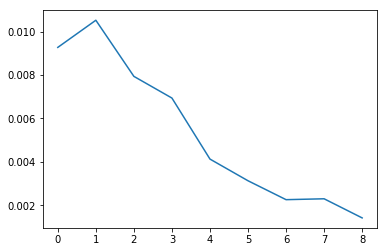

[0.009271083,
 0.010521897,
 0.007936254,
 0.006937376,
 0.0041262745,
 0.0031276383,
 0.0022567345,
 0.0022975064,
 0.0014163123]

In [80]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(np_features)
    labels = kmeans.labels_
    sil.append(silhouette_score(np_features, labels, metric = 'euclidean'))
plt.plot(sil)
plt.show()
sil

In [81]:

np_features = np.stack(features)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3,n_init=3,max_iter=10)
kmeans.fit(np_features)
kmeans.labels_



array([2, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 1, 1, 2, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 1,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1,
       2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 0, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 1, 0, 1, 0, 2, 1, 1, 1,
       2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 0, 2, 2,
       2, 1, 0, 2, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 1, 0, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 2,

(56,)
2


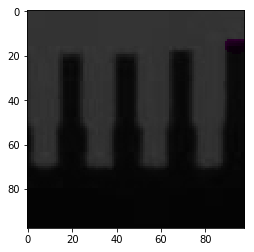

2


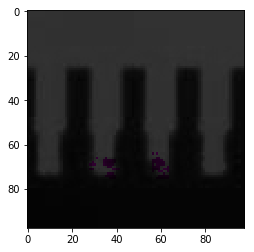

2


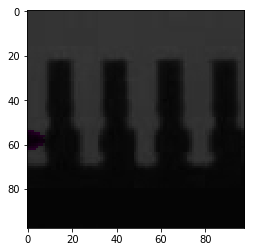

2


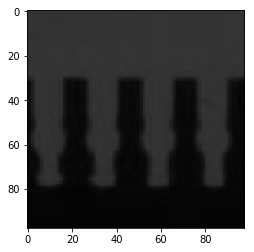

2


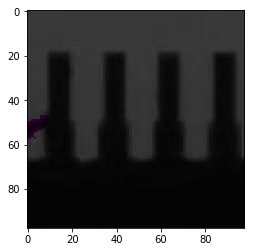

2


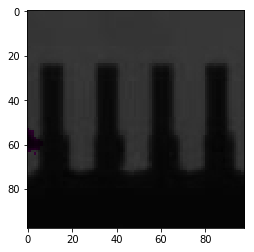

2


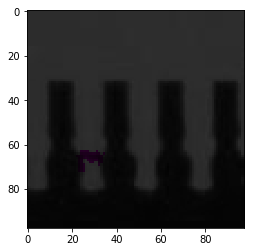

2


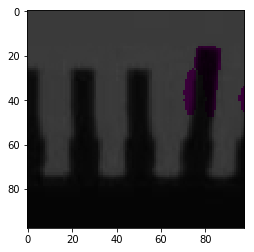

2


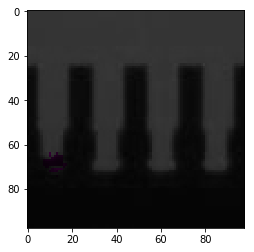

2


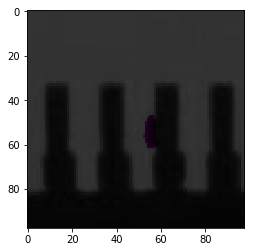

2


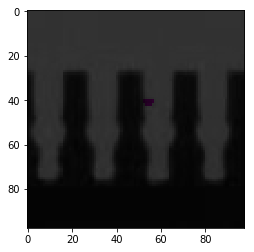

2


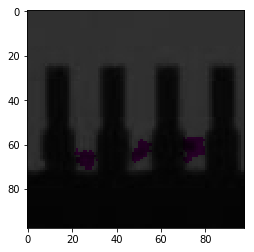

2


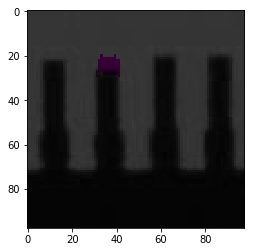

2


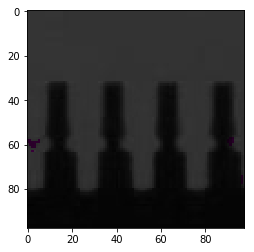

2


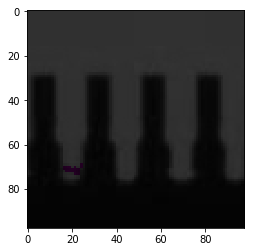

2


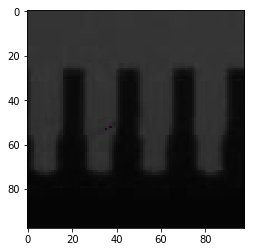

2


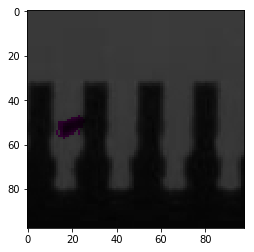

2


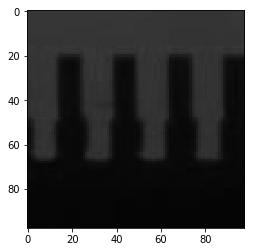

2


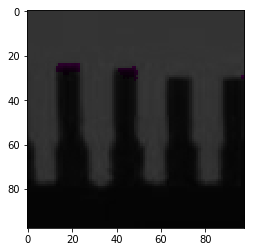

2


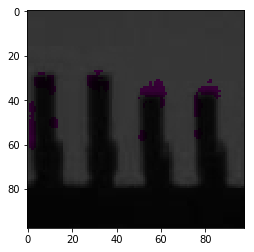

2


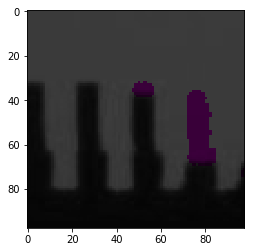

2


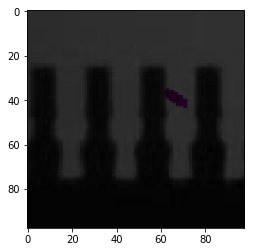

2


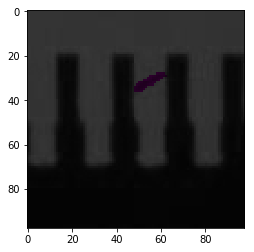

2


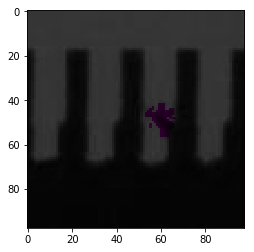

2


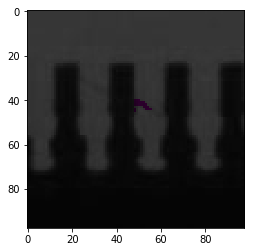

2


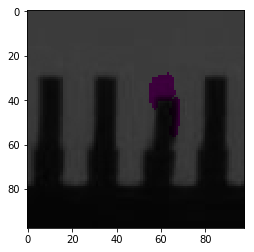

2


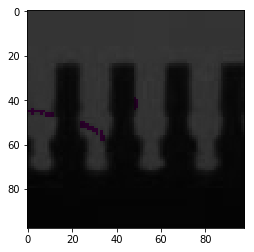

2


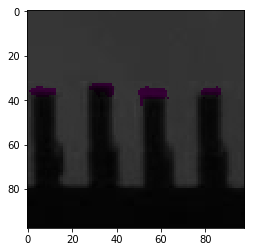

2


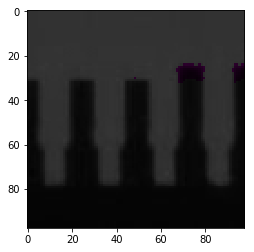

2


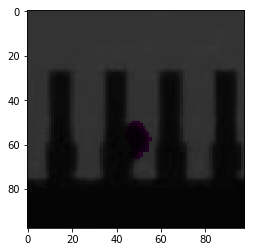

2


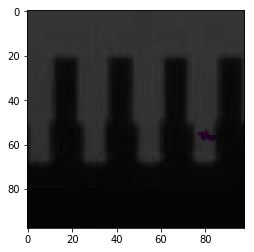

2


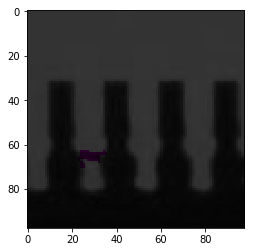

2


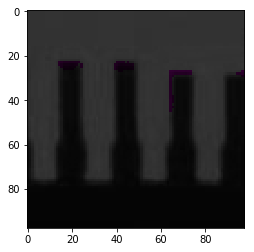

2


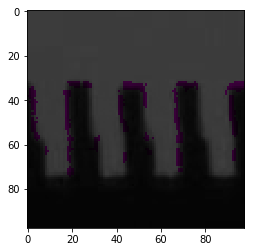

2


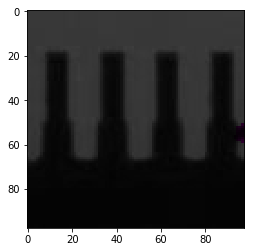

2


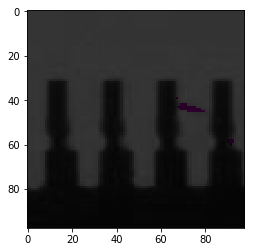

2


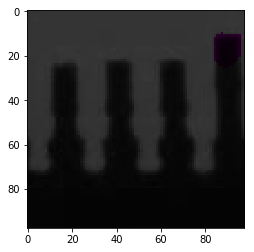

2


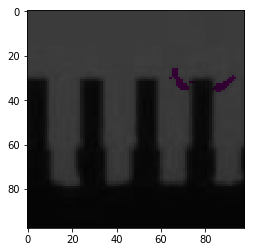

2


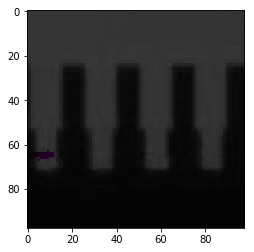

2


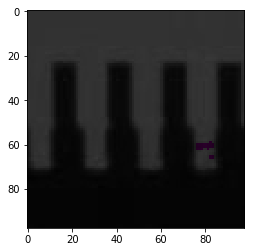

2


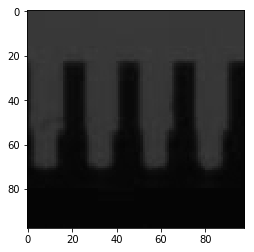

2


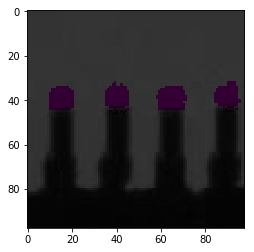

2


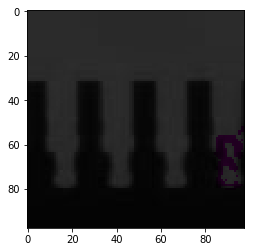

2


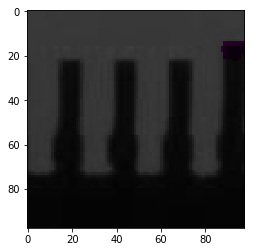

2


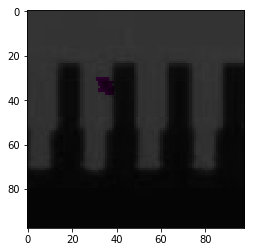

2


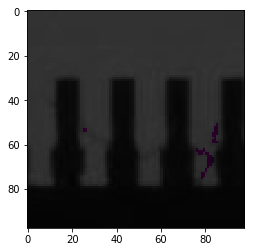

2


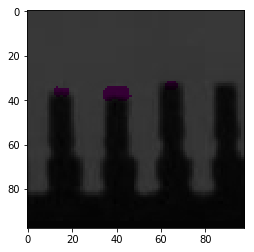

2


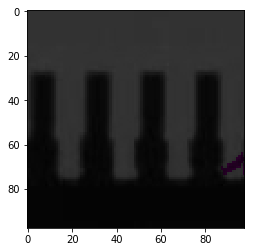

2


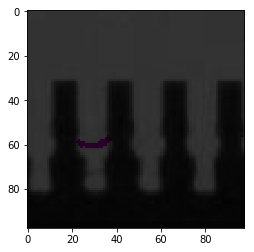

2


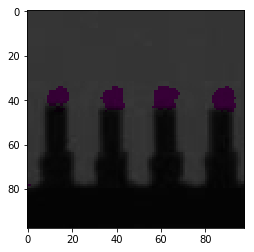

2


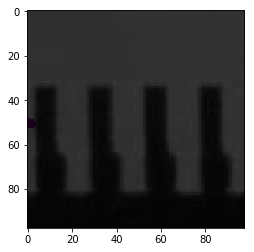

2


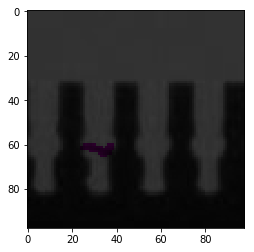

2


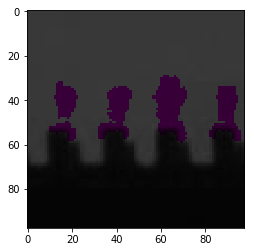

2


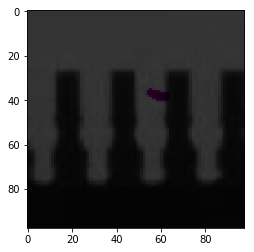

2


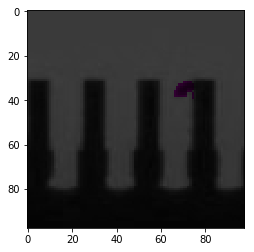

2


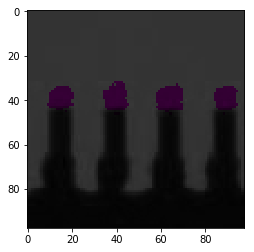

2


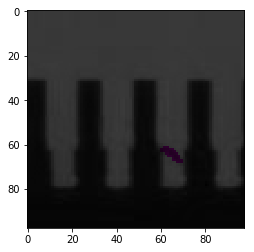

2


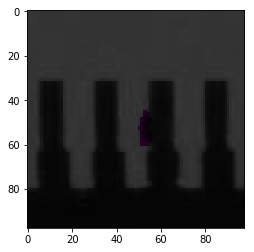

2


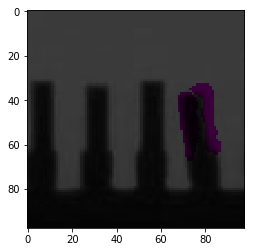

2


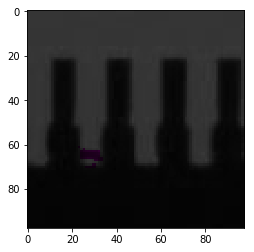

2


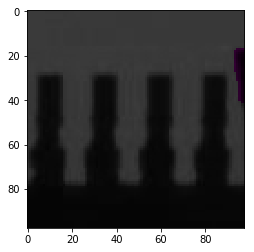

2


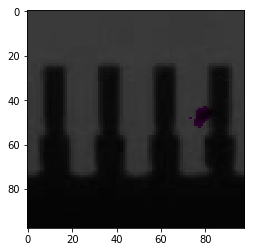

2


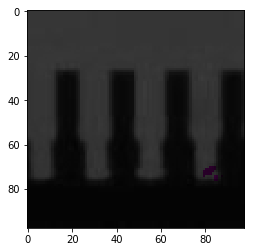

2


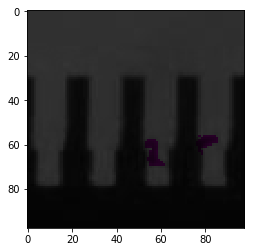

2


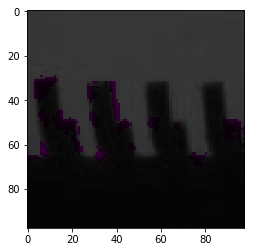

2


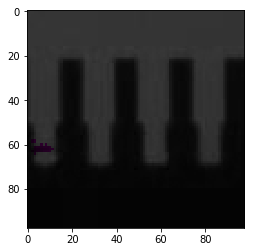

2


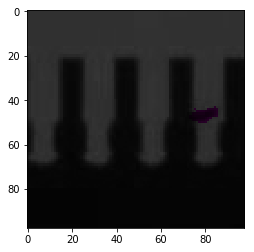

2


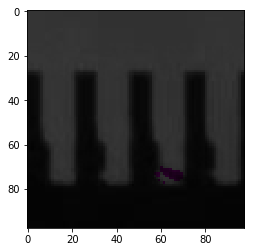

2


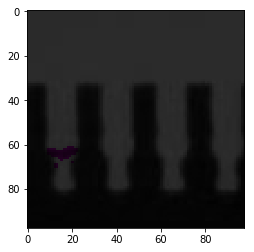

2


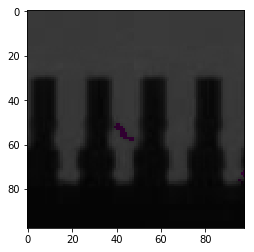

2


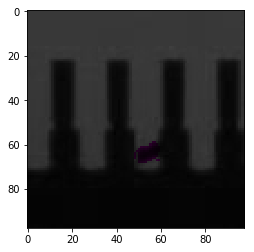

2


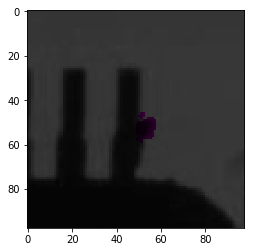

2


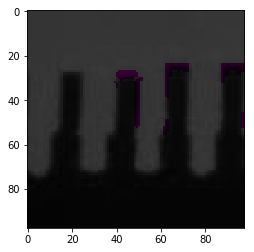

2


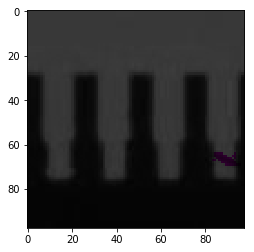

2


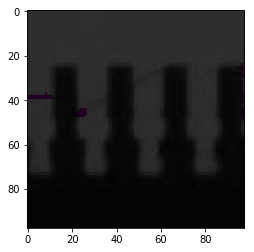

2


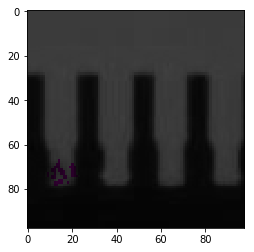

2


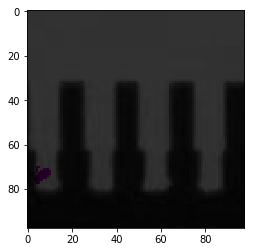

2


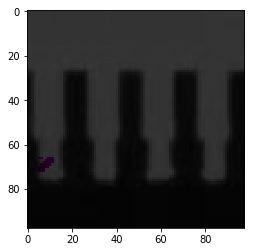

2


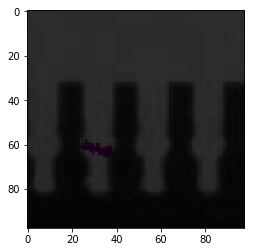

2


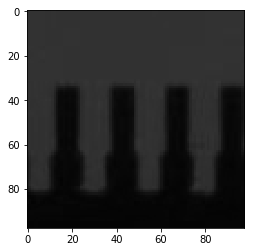

2


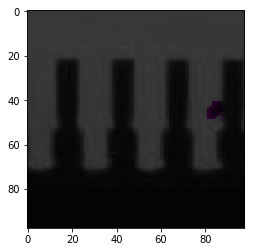

2


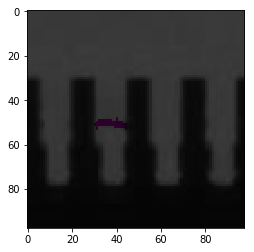

2


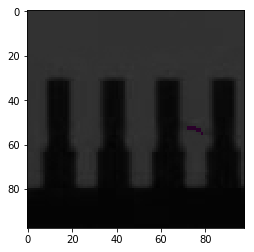

2


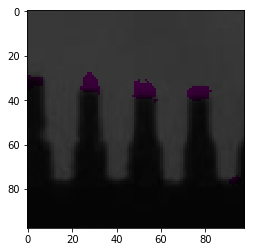

2


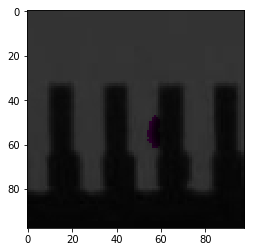

2


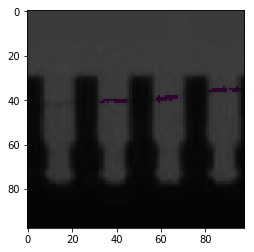

2


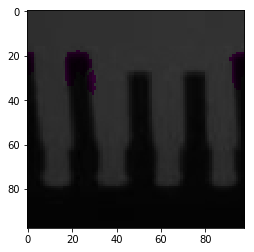

2


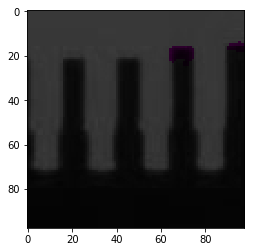

2


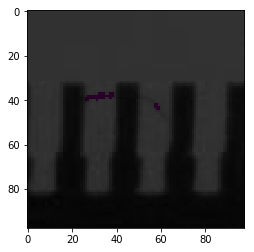

2


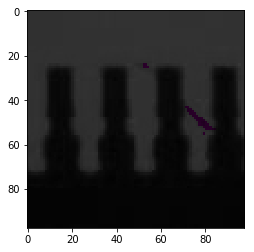

2


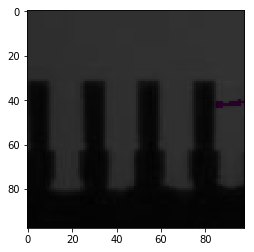

2


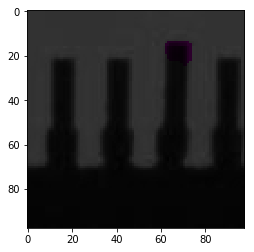

2


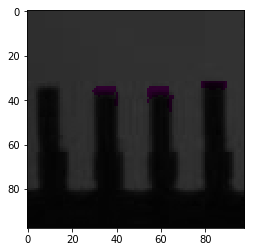

2


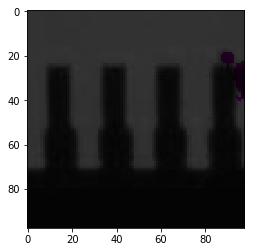

2


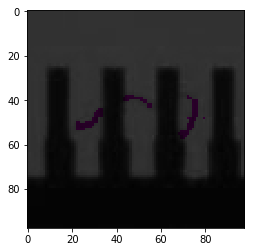

2


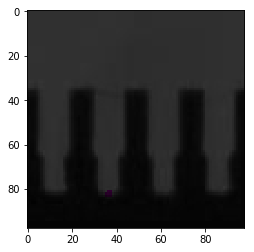

2


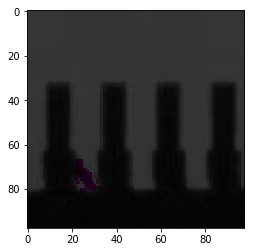

2


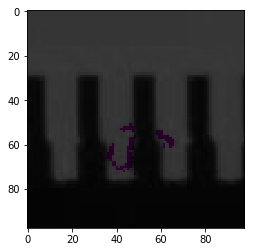

2


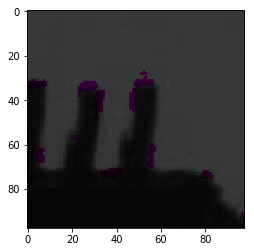

2


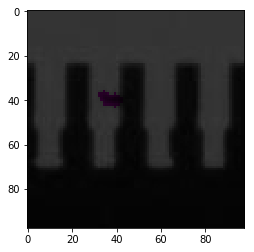

2


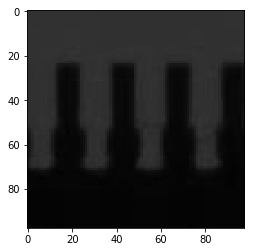

2


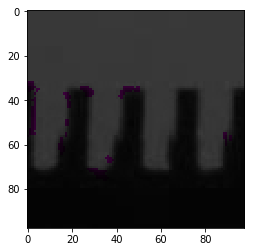

2


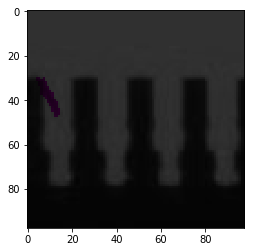

2


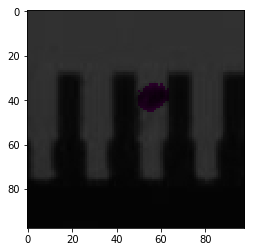

2


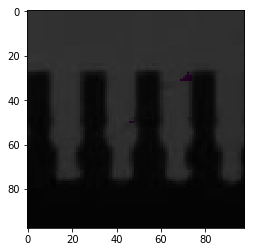

2


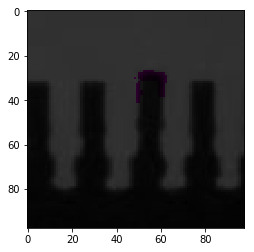

2


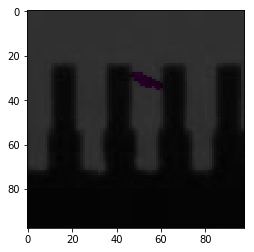

2


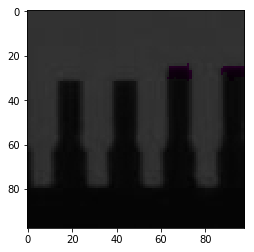

2


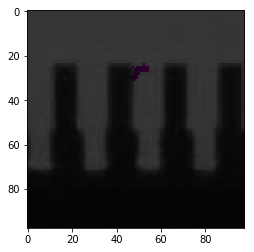

2


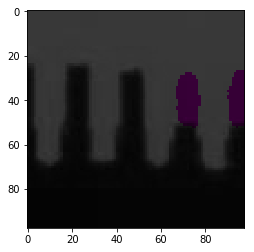

2


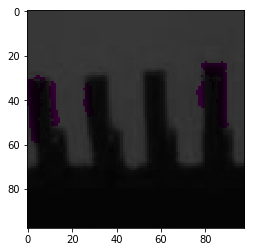

2


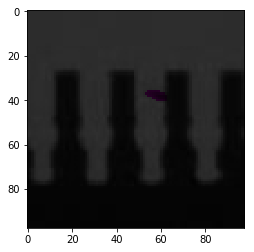

2


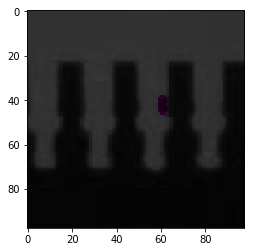

2


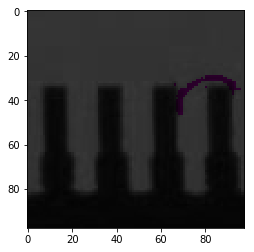

2


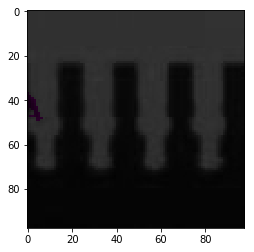

2


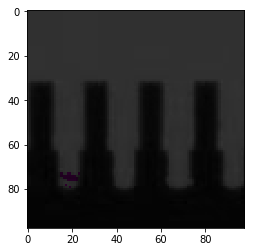

2


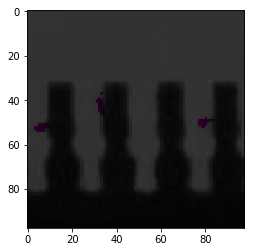

2


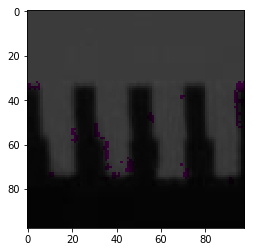

2


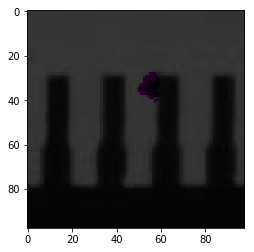

2


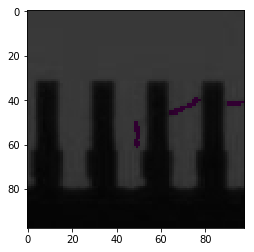

2


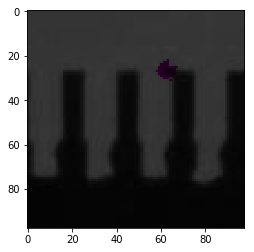

2


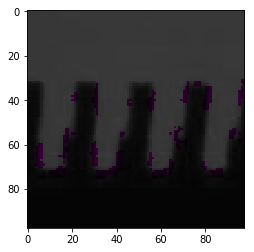

2


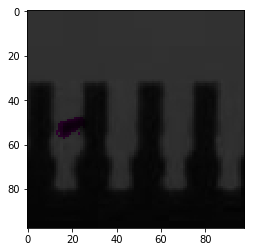

2


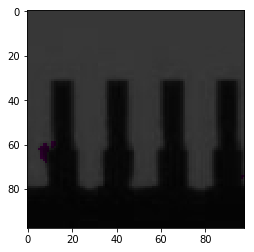

2


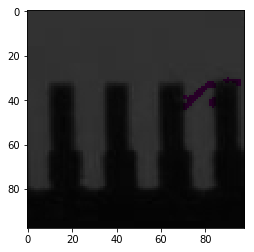

2


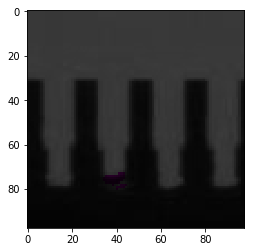

2


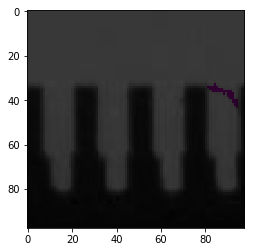

2


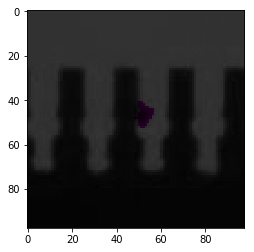

2


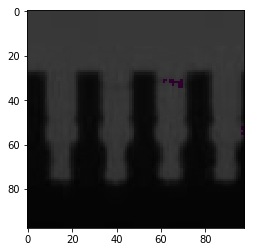

2


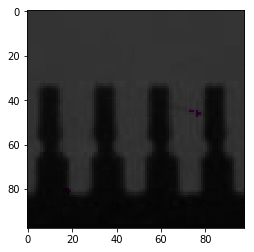

2


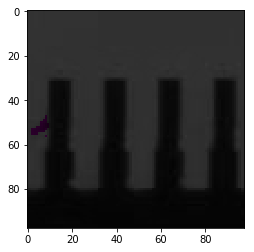

2


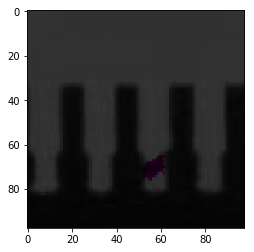

2


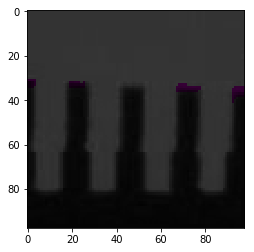

2


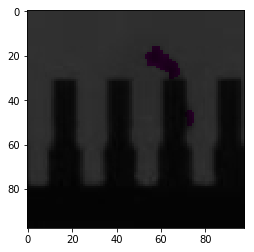

2


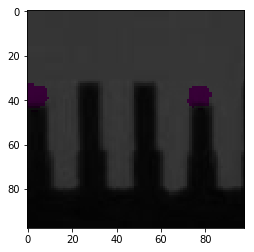

2


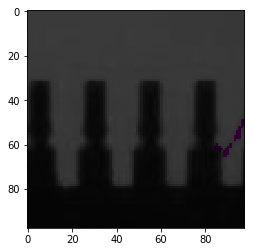

2


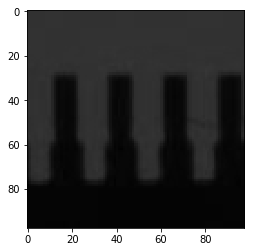

2


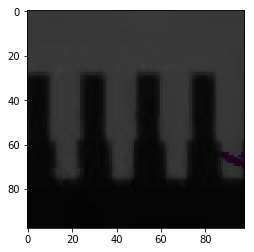

2


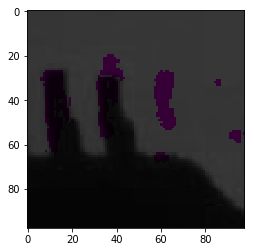

2


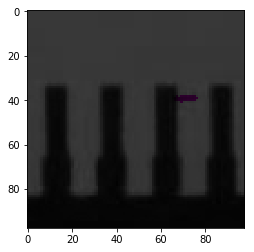

2


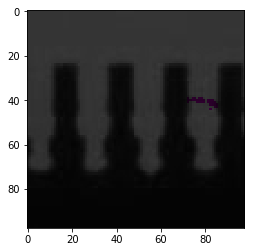

2


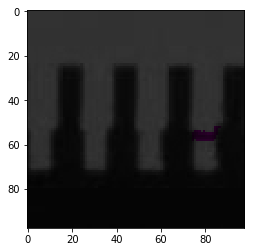

2


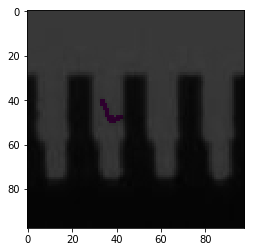

2


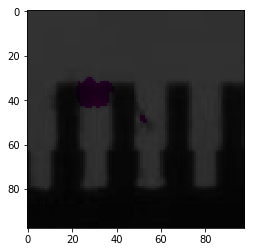

2


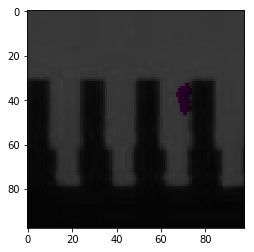

2


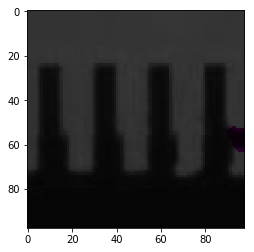

2


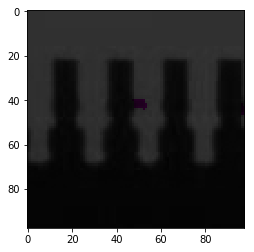

2


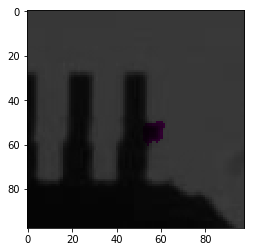

2


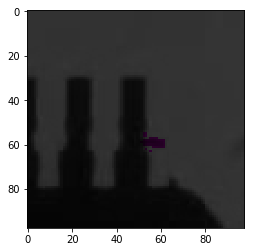

2


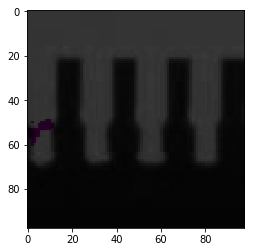

2


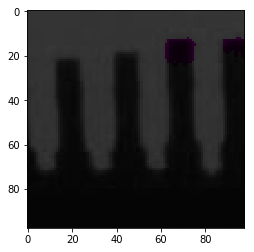

2


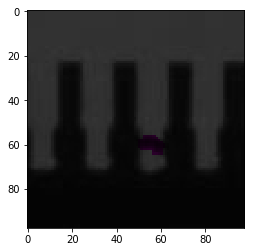

2


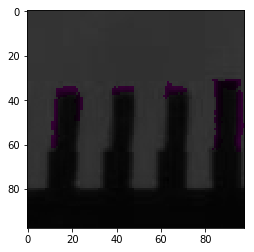

2


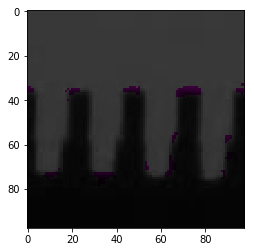

2


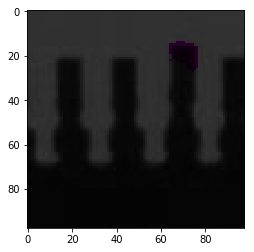

2


KeyboardInterrupt: 

In [84]:
print(kmeans.labels_[kmeans.labels_==0].shape)
 
for i,(img) in enumerate(imgs):
     
    img=img.reshape(98,98,3)
    if kmeans.labels_[i]==2:
        print (kmeans.labels_[i]) 
        plt.imshow(img,cmap='gray')
        plt.show()

In [ ]:
import pickle 
with open('clusters.pkl','wb') as f:
    pickle.dump(kmeans, f)
with open('clusters.pkl','rb') as f:
    km=pickle.load(f)
km.predict(np_features)